## Importing Modules

In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [6]:
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

In [7]:
#!pip install tensorflow

## Preparing the Data

### Making the functions to get the training and validation set from the Images

In [8]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='flowers/daisy'
FLOWER_SUNFLOWER_DIR='flowers/sunflower'
FLOWER_TULIP_DIR='flowers/tulip'
FLOWER_DANDI_DIR='flowers/dandelion'
FLOWER_ROSE_DIR='flowers/rose'

In [9]:
def assign_label(img,flower_type):
    return flower_type

In [10]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [11]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|████████████████████████████████████████| 764/764 [00:00<00:00, 901.78it/s]

764


In [12]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|████████████████████████████████████████| 733/733 [00:01<00:00, 720.62it/s]

1497


In [13]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|████████████████████████████████████████| 984/984 [00:01<00:00, 852.01it/s]

2481


In [14]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████████████████████████████████| 1052/1052 [00:01<00:00, 924.34it/s]

3533


### Visualization of Images

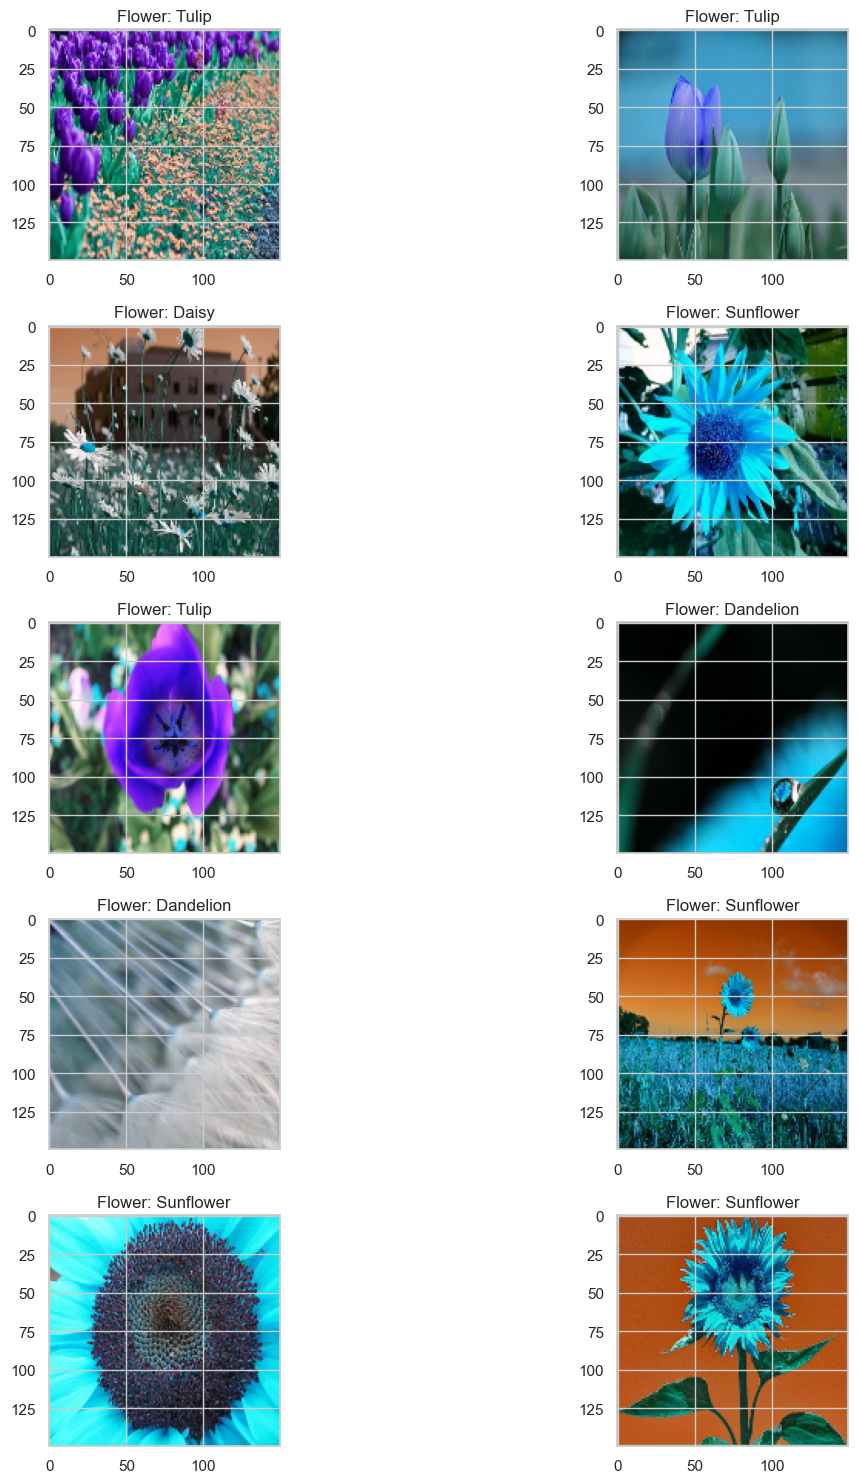

In [15]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

### Labeling and one hot encoding

In [16]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

### Splitting into Training and Validation Sets

In [17]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

### Setting the Random Seeds

In [22]:
import numpy as np
import random as rn
import tensorflow as tf

# Set seeds for reproducibility
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## Modelling

### Building the ConvNet Model

In [23]:
# modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

### Using a LR Annealer

In [24]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

### Data Augmentation to prevent Overfitting

In [25]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

### Compiling the Keras Model & Summary

In [27]:
# model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7776)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,981,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,143,749 (15.81 MB)

 Trainable params: 4,143,749 (15.81 MB)

 Non-trainable params: 0 (0.00 B)

###  Fitting on the Training set and making predcitons on the Validation set

In [30]:
# History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = (x_test,y_test),
#                               verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# # model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

History = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    verbose=1,
                    steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3130 - loss: 1.4778 - val_accuracy: 0.4638 - val_loss: 1.1894
Epoch 2/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4609 - loss: 1.1649

2024-04-01 09:26:50.249824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.4609 - loss: 0.6115 - val_accuracy: 0.5238 - val_loss: 1.0319
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5556 - loss: 0.9876 - val_accuracy: 0.6369 - val_loss: 0.9121
Epoch 4/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5703 - loss: 1.0696

2024-04-01 09:27:19.317269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.5703 - loss: 0.5615 - val_accuracy: 0.6618 - val_loss: 0.9097
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6343 - loss: 0.9207 - val_accuracy: 0.6312 - val_loss: 0.9616
Epoch 6/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7031 - loss: 0.8344

2024-04-01 09:27:48.709425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.7031 - loss: 0.4381 - val_accuracy: 0.6086 - val_loss: 0.9866
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6745 - loss: 0.8500 - val_accuracy: 0.6991 - val_loss: 0.8014
Epoch 8/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6641 - loss: 0.9585

2024-04-01 09:28:22.259098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.6641 - loss: 0.5032 - val_accuracy: 0.7048 - val_loss: 0.7787
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7042 - loss: 0.7793 - val_accuracy: 0.7059 - val_loss: 0.7578
Epoch 10/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7109 - loss: 0.7288

2024-04-01 09:28:54.972353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.7109 - loss: 0.3826 - val_accuracy: 0.7410 - val_loss: 0.7097
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7206 - loss: 0.7366 - val_accuracy: 0.7296 - val_loss: 0.7135
Epoch 12/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6719 - loss: 0.8136

2024-04-01 09:29:26.488323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.6719 - loss: 0.4272 - val_accuracy: 0.7443 - val_loss: 0.6861
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7357 - loss: 0.7023 - val_accuracy: 0.7251 - val_loss: 0.7179
Epoch 14/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 15s 795ms/step - accuracy: 0.7416 - loss: 0.7217

2024-04-01 09:29:59.277996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.7416 - loss: 0.3789 - val_accuracy: 0.7387 - val_loss: 0.7001
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7454 - loss: 0.6936 - val_accuracy: 0.7432 - val_loss: 0.6859
Epoch 16/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7109 - loss: 0.8039

2024-04-01 09:30:30.725843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.7109 - loss: 0.4220 - val_accuracy: 0.7477 - val_loss: 0.6820
Epoch 17/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7676 - loss: 0.6590 - val_accuracy: 0.7466 - val_loss: 0.6646
Epoch 18/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7188 - loss: 0.7714

2024-04-01 09:31:03.040059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.7188 - loss: 0.4050 - val_accuracy: 0.7579 - val_loss: 0.6171
Epoch 19/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7575 - loss: 0.6432 - val_accuracy: 0.7692 - val_loss: 0.6251
Epoch 20/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7734 - loss: 0.6129

2024-04-01 09:31:32.995754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.7734 - loss: 0.3218 - val_accuracy: 0.7670 - val_loss: 0.6237
Epoch 21/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7779 - loss: 0.6111 - val_accuracy: 0.7907 - val_loss: 0.5824
Epoch 22/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7656 - loss: 0.5847

2024-04-01 09:32:06.368646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.7656 - loss: 0.3070 - val_accuracy: 0.7873 - val_loss: 0.5837
Epoch 23/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7845 - loss: 0.5950 - val_accuracy: 0.7511 - val_loss: 0.6372
Epoch 24/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7344 - loss: 0.6495

2024-04-01 09:32:37.903298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.7344 - loss: 0.3410 - val_accuracy: 0.7534 - val_loss: 0.6217
Epoch 25/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7684 - loss: 0.5937 - val_accuracy: 0.7738 - val_loss: 0.6110
Epoch 26/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7500 - loss: 0.6758

2024-04-01 09:33:09.222787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.7500 - loss: 0.3548 - val_accuracy: 0.7704 - val_loss: 0.5884
Epoch 27/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7852 - loss: 0.5768 - val_accuracy: 0.7896 - val_loss: 0.5586
Epoch 28/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 16s 888ms/step - accuracy: 0.7753 - loss: 0.6679

2024-04-01 09:33:42.312964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.7753 - loss: 0.3507 - val_accuracy: 0.8100 - val_loss: 0.5327
Epoch 29/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7992 - loss: 0.5497 - val_accuracy: 0.7964 - val_loss: 0.5570
Epoch 30/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8359 - loss: 0.5007

2024-04-01 09:34:16.481759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.8359 - loss: 0.2629 - val_accuracy: 0.7862 - val_loss: 0.5849
Epoch 31/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8084 - loss: 0.5322 - val_accuracy: 0.7817 - val_loss: 0.6079
Epoch 32/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8828 - loss: 0.4372

2024-04-01 09:34:47.764806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.8828 - loss: 0.2295 - val_accuracy: 0.7828 - val_loss: 0.5927
Epoch 33/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8043 - loss: 0.5337 - val_accuracy: 0.7964 - val_loss: 0.5940
Epoch 34/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6797 - loss: 0.7317

2024-04-01 09:35:21.353235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.6797 - loss: 0.3842 - val_accuracy: 0.8066 - val_loss: 0.5418
Epoch 35/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8207 - loss: 0.4953 - val_accuracy: 0.8122 - val_loss: 0.4988
Epoch 36/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9062 - loss: 0.4063

2024-04-01 09:35:53.057550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9062 - loss: 0.2133 - val_accuracy: 0.8032 - val_loss: 0.5032
Epoch 37/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8264 - loss: 0.4758 - val_accuracy: 0.7941 - val_loss: 0.5735
Epoch 38/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 14s 738ms/step - accuracy: 0.8202 - loss: 0.5214

2024-04-01 09:36:24.948756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.8202 - loss: 0.2737 - val_accuracy: 0.8077 - val_loss: 0.5247
Epoch 39/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8119 - loss: 0.5304 - val_accuracy: 0.7885 - val_loss: 0.6189
Epoch 40/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8359 - loss: 0.5604

2024-04-01 09:36:57.996983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.8359 - loss: 0.2942 - val_accuracy: 0.8043 - val_loss: 0.5335
Epoch 41/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8363 - loss: 0.4408 - val_accuracy: 0.8133 - val_loss: 0.5212
Epoch 42/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8359 - loss: 0.5134

2024-04-01 09:37:29.877784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.8359 - loss: 0.2695 - val_accuracy: 0.8020 - val_loss: 0.5358
Epoch 43/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8355 - loss: 0.4659 - val_accuracy: 0.8100 - val_loss: 0.5206
Epoch 44/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8516 - loss: 0.4367

2024-04-01 09:38:01.824906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8516 - loss: 0.2293 - val_accuracy: 0.8269 - val_loss: 0.4920
Epoch 45/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8351 - loss: 0.4487 - val_accuracy: 0.7376 - val_loss: 0.7324
Epoch 46/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7734 - loss: 0.5680

2024-04-01 09:38:32.917231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.7734 - loss: 0.2982 - val_accuracy: 0.7964 - val_loss: 0.5616
Epoch 47/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8258 - loss: 0.4828 - val_accuracy: 0.8348 - val_loss: 0.4867
Epoch 48/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8203 - loss: 0.4161

2024-04-01 09:39:03.509050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.8203 - loss: 0.2185 - val_accuracy: 0.8337 - val_loss: 0.4835
Epoch 49/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8366 - loss: 0.4396 - val_accuracy: 0.8281 - val_loss: 0.4904
Epoch 50/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8359 - loss: 0.3991

2024-04-01 09:39:34.731579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.8359 - loss: 0.2095 - val_accuracy: 0.8167 - val_loss: 0.4980


## Evaluating the Model Performance

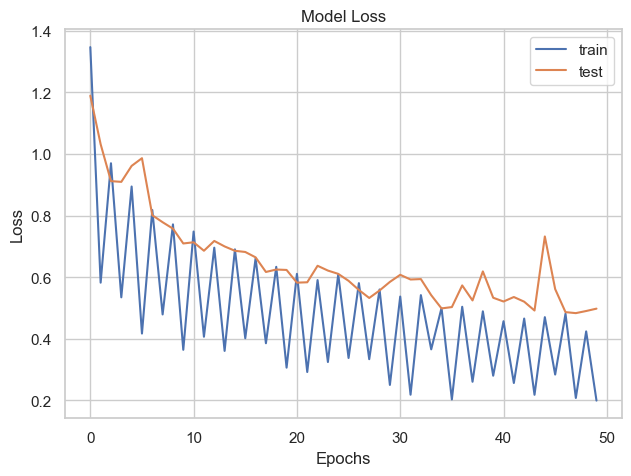

In [31]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

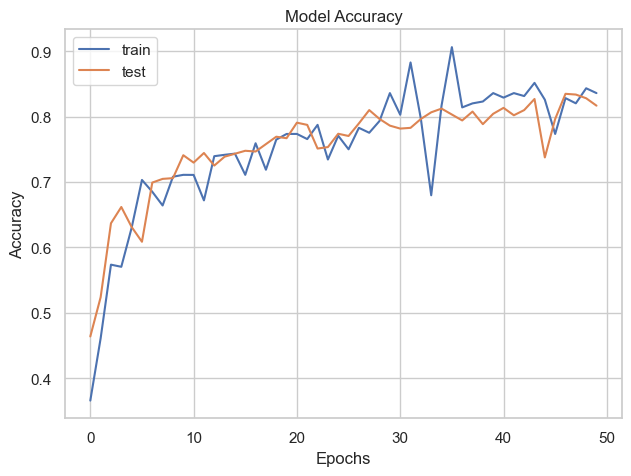

In [43]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## Visualizing Predictons on the Validation Set

In [35]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


In [36]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

#### CORRECTLY CLASSIFIED FLOWER IMAGES

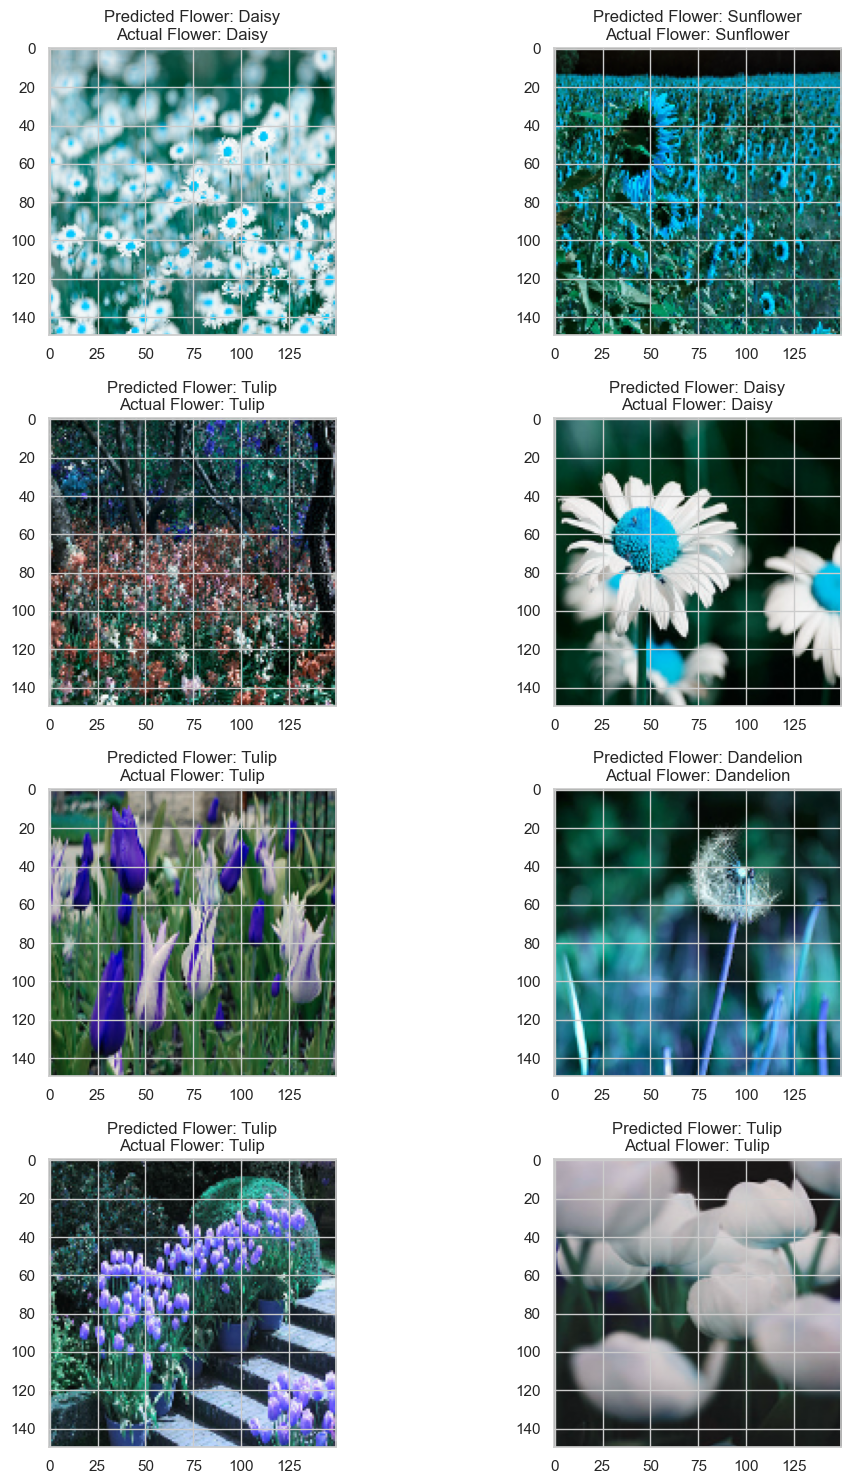

In [38]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# count=0
# fig,ax=plt.subplots(4,2)
# fig.set_size_inches(15,15)
# for i in range (4):
#     for j in range (2):
#         ax[i,j].imshow(x_test[prop_class[count]])
#         ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]]))))
#         plt.tight_layout()
#         count+=1

count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)
for i in range(4):
    for j in range(2):
        # Convert predictions and actual labels to 1D arrays
        pred_label = le.inverse_transform([pred_digits[prop_class[count]]])[0]
        actual_label = le.inverse_transform([np.argmax(y_test[prop_class[count]])])[0]
        
        ax[i, j].imshow(x_test[prop_class[count]])
        ax[i, j].set_title("Predicted Flower: " + str(pred_label) + "\n" + "Actual Flower: " + str(actual_label))
        plt.tight_layout()
        count += 1

#### MISCLASSIFIED IMAGES OF FLOWERS

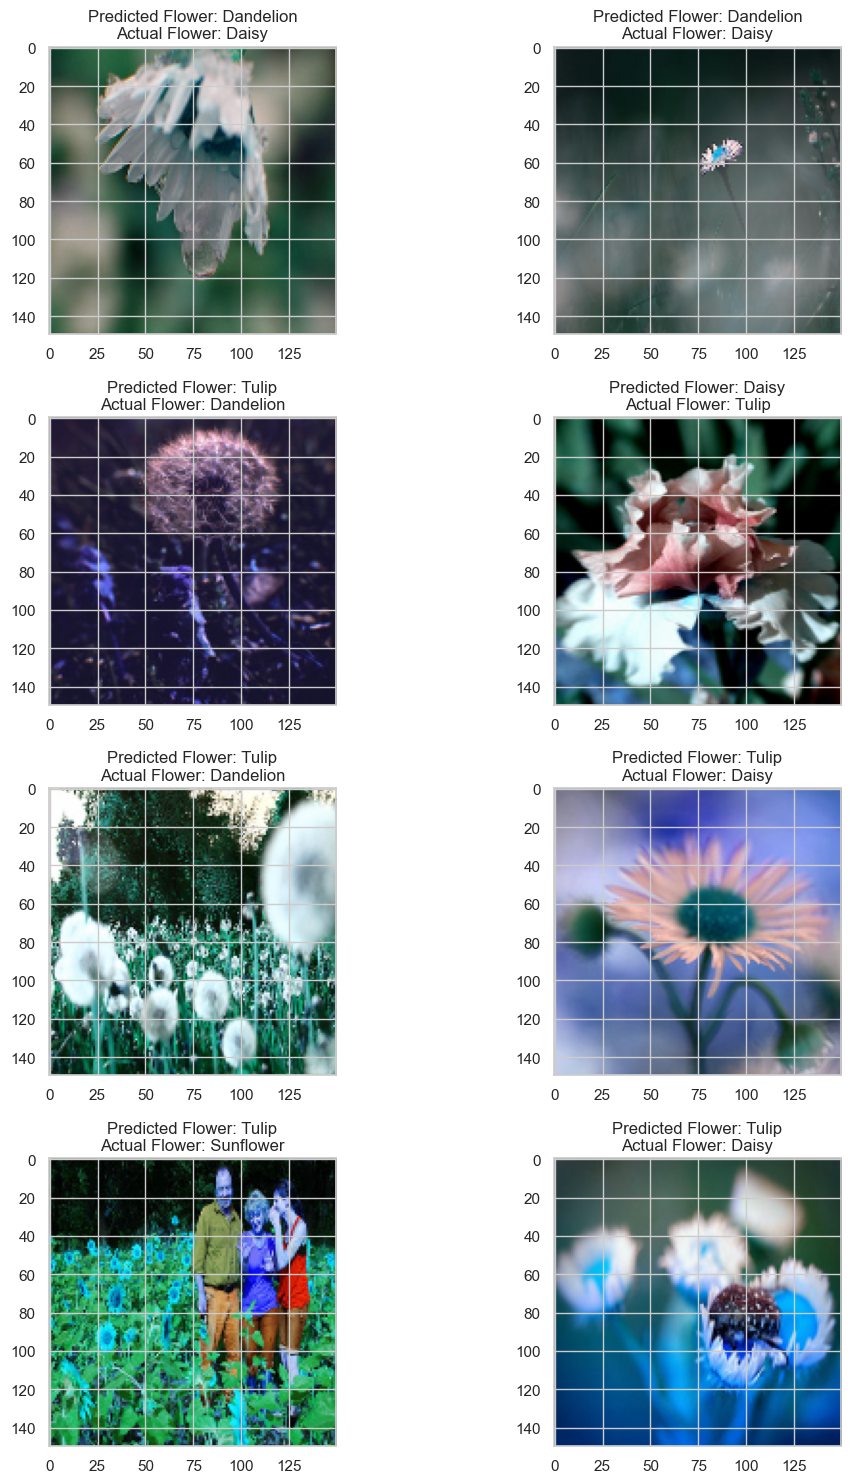

In [41]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# count=0
# fig,ax=plt.subplots(4,2)
# fig.set_size_inches(15,15)
# for i in range (4):
#     for j in range (2):
#         ax[i,j].imshow(x_test[mis_class[count]])
#         ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]]))))
#         plt.tight_layout()
#         count+=1

count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)
for i in range(4):
    for j in range(2):
        # Convert predictions and actual labels to 1D arrays
        pred_label = le.inverse_transform([pred_digits[mis_class[count]]])[0]
        actual_label = le.inverse_transform([np.argmax(y_test[mis_class[count]])])[0]
        
        ax[i, j].imshow(x_test[mis_class[count]])
        ax[i, j].set_title("Predicted Flower: " + str(pred_label) + "\n" + "Actual Flower: " + str(actual_label))
        plt.tight_layout()
        count += 1
